## Imports

In [284]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import datetime
import squarify

sns.set(style="whitegrid")
%matplotlib inline

In [285]:
# bom_df = pd.read_csv('Data/bom.movie_gross.csv')
# imdb_name_df = pd.read_csv('Data/imdb.name.basics.csv')
# imdb_akas_df = pd.read_csv('Data/imdb.title.akas.csv')
# imdb_basics_df = pd.read_csv('Data/imdb.title.basics.csv')
# imbd_crew_df = pd.read_csv('Data/imdb.title.crew.csv')
# imdb_principals_df = pd.read_csv('Data/imdb.title.principals.csv')
# imdb_ratings_df = pd.read_csv('Data/imdb.title.ratings.csv')
# rt_info_df = pd.read_csv('Data/rt.movie_info.tsv', sep = '\t')
# rt_reviews_df = pd.read_csv('Data/rt.reviews.tsv', sep = '\t', encoding ='ISO-8859-1')
# tmdb_movies_df = pd.read_csv('Data/tmdb.movies.csv')
# tn_budgets_df = pd.read_csv('Data/tn.movie_budgets.csv')

tmdb_data = pd.read_csv('Data/tmdb_movies_data.csv')
oscars = pd.read_csv('Data/oscars.csv')

## Data Cleaning

#### Oscars Cleaning

In [286]:
oscars = oscars[(oscars['year'] >= 2000) & (oscars['year'] <= 2019)]
nominations = oscars.groupby('entity').count()['winner']
nominations.size

1462

#### TMDB Cleaning

In [287]:
tmdb_data.drop(columns = ['id', 'homepage', 'tagline', 'keywords', 'overview', 'runtime', 'production_companies', 'release_date'], inplace = True)
tmdb_data['cast'] = tmdb_data['cast'].apply(lambda x: str(x).split('|'))
tmdb_data['genres'] = tmdb_data['genres'].apply(lambda x: str(x).split('|'))
tmdb_cleaned = tmdb_data.sort_values(by = ['revenue_adj'], ascending = False)
tmdb_cleaned = tmdb_cleaned[~tmdb_cleaned.director.isna()]
tmdb_cleaned = tmdb_cleaned.drop_duplicates(subset ="imdb_id", keep = False)
tmdb_cleaned = tmdb_cleaned[(tmdb_cleaned['release_year'] >= 2000) &(tmdb_cleaned['release_year'] <=2019)]
tmdb_cleaned['budget'] = tmdb_data['budget']/1000000
tmdb_cleaned['revenue'] = tmdb_data['revenue']/1000000
tmdb_cleaned['budget_adj'] = tmdb_cleaned['budget_adj']/1000000
tmdb_cleaned['revenue_adj'] = tmdb_cleaned['revenue_adj']/1000000
tmdb_cleaned['profit'] = tmdb_cleaned['revenue_adj'] - tmdb_cleaned['budget_adj']
tmdb_cleaned.shape

(7121, 14)

#### Merge Data

In [288]:
merged_data = tmdb_cleaned
merged_data = merged_data.merge(nominations, left_on = 'original_title', right_on = 'entity', how = 'left')
merged_data.rename(columns = {'winner': 'nominations'}, inplace = True)
merged_data.shape

(7121, 15)

#### Generate Genres Data Frame From Merged Data

In [289]:
comedies = merged_data[merged_data['genres'].apply(lambda x: 'Comedy' in x)]
dramas = merged_data[merged_data['genres'].apply(lambda x: 'Drama' in x)]
horrors = merged_data[merged_data['genres'].apply(lambda x: 'Horror' in x)]
adventures = merged_data[merged_data['genres'].apply(lambda x: 'Adventure' in x)]
fantasies = merged_data[merged_data['genres'].apply(lambda x: 'Fantasy' in x)]
thrillers = merged_data[merged_data['genres'].apply(lambda x: 'Thriller' in x)]
science_fictions = merged_data[merged_data['genres'].apply(lambda x: 'Science Fiction' in x)]
actions = merged_data[merged_data['genres'].apply(lambda x: 'Action' in x)]
crimes = merged_data[merged_data['genres'].apply(lambda x: 'Crime' in x)]
families = merged_data[merged_data['genres'].apply(lambda x: 'Family' in x)]
animations = merged_data[merged_data['genres'].apply(lambda x: 'Animation' in x)]
mysteries = merged_data[merged_data['genres'].apply(lambda x: 'Mystery' in x)]

genres = [comedies, dramas, horrors, adventures, fantasies, thrillers, science_fictions, actions, crimes, families, animations, mysteries]
genres_names = ['comedy', 'drama', 'horror', 'adventure', 'fantasy', 'thriller', 'science fiction', 'action', 'crime', 'family', 'animation', 'mystery']

revenues_adj_mean = []
budget_adj_mean = []
oscar_nominations = []

for genre in genres:
    revenues_adj_mean.append(genre.mean()['revenue_adj'])
    budget_adj_mean.append(genre.mean()['budget_adj'])
    oscar_nominations.append(genre.sum()['nominations'])

to_df = []
for i in range(len(genres_names)):
    my_list = [genres_names[i], budget_adj_mean[i], revenues_adj_mean[i], oscar_nominations[i]]
    to_df.append(my_list)

genres_df = pd.DataFrame(to_df, columns = ['genre', 'budget', 'revenue', 'oscar_nominations'])
genres_df.sort_values(by = ['revenue'], inplace = True, ascending = False)
genres_df['profit'] = genres_df['revenue'] - genres_df['budget']
genres_df = genres_df.reset_index().drop(columns = ['index'])
genres_df.shape

(12, 5)

#### Creating Other Data Frames To Analyze Genres

In [290]:
drama_adventure = merged_data[merged_data['genres'].apply(lambda x: ('Drama' in x) & ('Adventure' in x))].sort_values(by = ['profit'], ascending = False)
drama_fantasy = merged_data[merged_data['genres'].apply(lambda x: ('Drama' in x) & ('Fantasy' in x))].sort_values(by = ['profit'], ascending = False)
drama_comedy = merged_data[merged_data['genres'].apply(lambda x: ('Drama' in x) & ('Comedy' in x))].sort_values(by = ['profit'], ascending = False)
drama_adventure_oscars = drama_adventure.merge(nominations, left_on = 'original_title', right_on = 'entity', how = 'inner')
drama_fantasy_oscars = drama_fantasy.merge(nominations, left_on = 'original_title', right_on = 'entity', how = 'inner')
drama_comedy_oscars = drama_comedy.merge(nominations, left_on = 'original_title', right_on = 'entity', how = 'inner')
print(len(drama_adventure_oscars['original_title']), len(drama_fantasy_oscars['original_title']), len(drama_comedy_oscars['original_title']))

24 12 42


#### Make A Data Frame Showing Directors Who Have Worked on Drama-Adventure Oscar-Nominated Films

In [291]:
directors = drama_adventure[drama_adventure['profit'] > 10].groupby('director')
directors_oscars = drama_adventure[(drama_adventure['profit'] > 10) & (drama_adventure['nominations'] > 0)].groupby('director')
#directors_by_profit = directors.mean().sort_values(by = ['profit'], ascending = False)[:10]
directors_by_profit_oscars = directors_oscars.mean().sort_values(by = ['profit'], ascending = False)[:10]
directors_by_profit_oscars.rename(index = {'Alejandro GonzÃ¡lez IÃ±Ã¡rritu': 'Alejandro Gonzalez Inarritu'}, inplace = True)
directors_by_profit_oscars.rename(index = {'Ethan Coen|Joel Coen': 'Coen Brothers'}, inplace = True)




#### Make A Data Frame Showing Highest Average-Grossing Drama-Adventure Actors 

In [292]:
casts = drama_adventure_oscars[['cast', 'profit', 'popularity']]
casts_actors = casts['cast'].values 
casts_profits = casts['profit'].values

casts_n_profit = []
for i, actors in enumerate(casts_actors):
    to_append = (actors, casts_profits[i])
    casts_n_profit.append(to_append)

actors_dict = {}
for tup in casts_n_profit:
    for actor in tup[0]:
        x = str(actor)
        if x == 'Michael PeÃ±a':
            x = 'Michael Pena'
        if x in actors_dict:
            actors_dict[x] += tup[1]/2 # this is to get the mean
        else:
            actors_dict[x] = tup[1]

sorted_actors = sorted(actors_dict.items(), key = lambda x: x[1], reverse = True)
actors = sorted_actors[:30]
actors = actors[0:3] + actors[8:]
actors


[('Jessica Chastain', 658.74500887),
 ('Matt Damon', 555.5281615199999),
 ('Jude Law', 532.48668563),
 ('Russell Crowe', 449.0783761),
 ('Joaquin Phoenix', 449.0783761),
 ('Connie Nielsen', 449.0783761),
 ('Oliver Reed', 449.0783761),
 ('Richard Harris', 449.0783761),
 ('Kristen Wiig', 448.38969801999997),
 ('Jeff Daniels', 448.38969801999997),
 ('Michael Pena', 448.38969801999997),
 ('Robert Downey Jr.', 441.14693773000005),
 ('Rachel McAdams', 441.14693773000005),
 ('Mark Strong', 441.14693773000005),
 ('Eddie Marsan', 441.14693773000005),
 ('Tom Hanks', 430.0735032),
 ('Helen Hunt', 430.0735032),
 ('Chris Noth', 430.0735032),
 ('Paul Sanchez', 430.0735032),
 ('Lari White', 430.0735032),
 ('Matthew McConaughey', 420.7106217),
 ('Anne Hathaway', 420.7106217),
 ('Michael Caine', 420.7106217),
 ('Casey Affleck', 420.7106217),
 ('Naomi Watts', 382.98120829999993)]

#### Save our data frames and variables with 'pickle'

In [293]:
with open ('my_pickles/merged_data.p', 'wb') as writefile: 
    pickle.dump(merged_data, writefile)
with open ('my_pickles/genres_df.p', 'wb') as writefile: 
    pickle.dump(genres_df, writefile)
with open ('my_pickles/directors_by_profit_oscars.p', 'wb') as writefile: 
    pickle.dump(directors_by_profit_oscars, writefile)
with open ('my_pickles/nominations.p', 'wb') as writefile: 
    pickle.dump(nominations, writefile)
with open ('my_pickles/tmdb_cleaned.p', 'wb') as writefile: 
    pickle.dump(tmdb_cleaned, writefile)
with open ('my_pickles/genres_names.p', 'wb') as writefile: 
    pickle.dump(genres_names, writefile)
with open ('my_pickles/actors.p', 'wb') as writefile: 
    pickle.dump(actors, writefile)

## Visualizations

#### Genre Visualizations

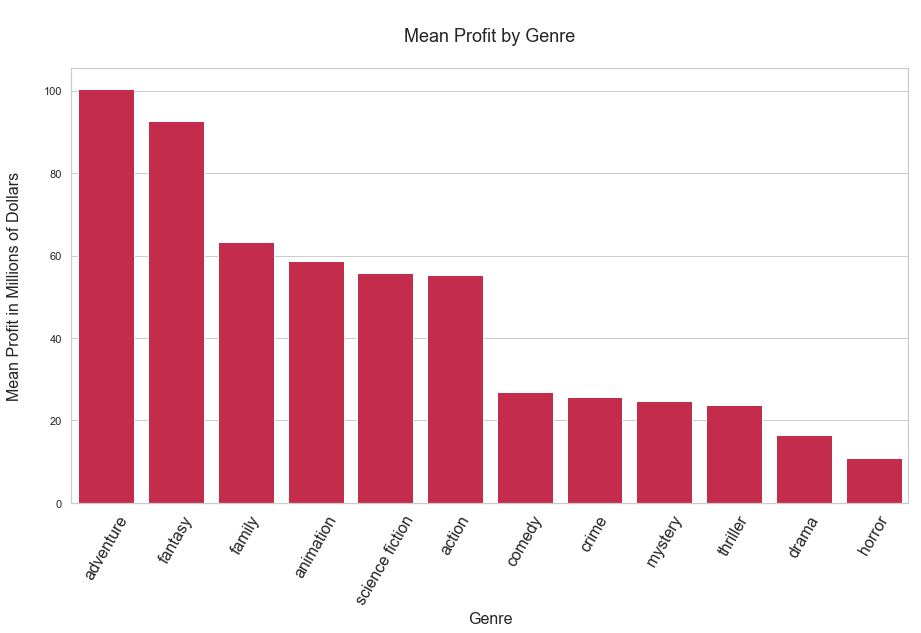

In [294]:
genres_df.sort_values(by = ['profit'], inplace = True, ascending = False)
plt.figure(figsize = (15,8))
sns.barplot(x = 'genre', y = 'profit', data = genres_df, color = 'crimson')
plt.title('\nMean Profit by Genre\n', fontsize = 18)
plt.ylabel('Mean Profit in Millions of Dollars\n', fontsize = 16)
plt.xticks(rotation=60, fontsize = 16)
plt.xlabel('Genre', fontsize = 16)
plt.xticks(fontsize = 16)
plt.show()

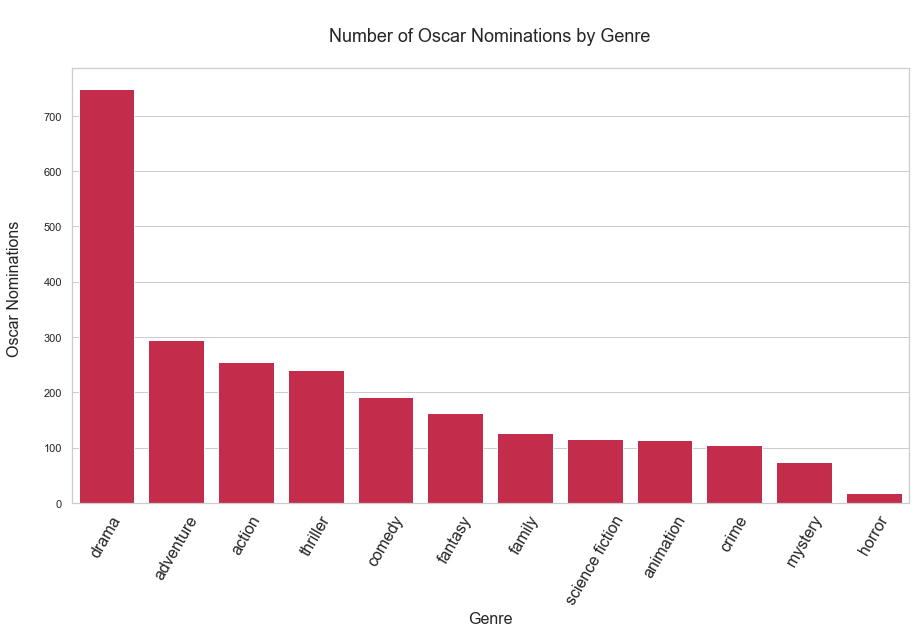

In [295]:
genres_df.sort_values(by = ['oscar_nominations'], ascending = False, inplace = True)


plt.figure(figsize = (15,8))
sns.barplot(x = 'genre', y = 'oscar_nominations', data = genres_df, color = 'crimson')
plt.xticks(rotation=60, fontsize = 16)
plt.xlabel('Genre', fontsize = 16)
plt.ylabel('Oscar Nominations \n', fontsize = 16)
plt.title('\nNumber of Oscar Nominations by Genre\n', fontsize = 18)
plt.show()

#### Director Visualizations

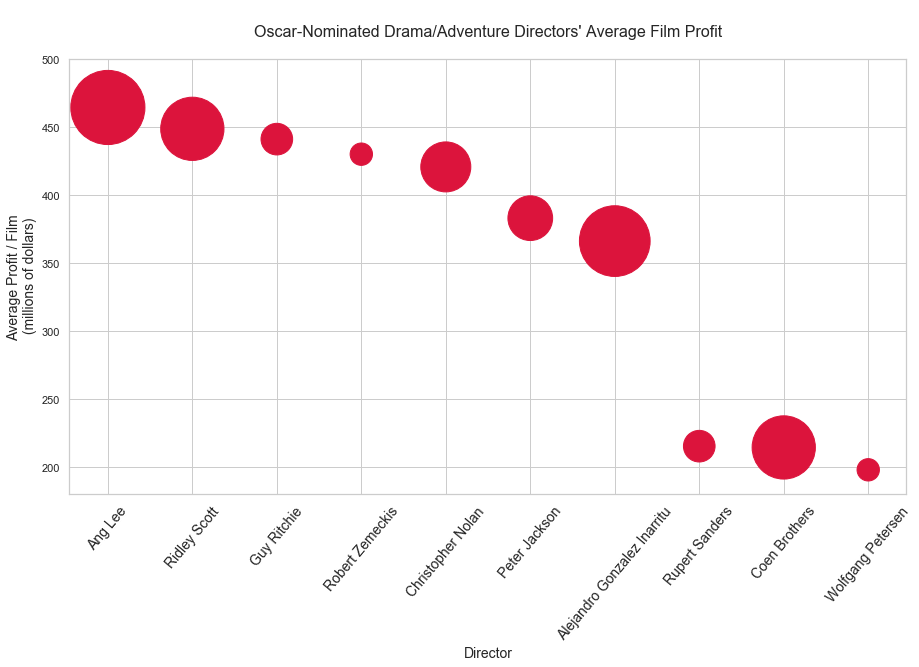

In [298]:
plt.figure(figsize = (15,8))
plt.scatter(x = directors_by_profit_oscars.index, y = directors_by_profit_oscars['profit'], s = (directors_by_profit_oscars['nominations'])*500, color = 'crimson')

plt.ylim(180, 500)

plt.xticks(rotation=50, fontsize = 14)
plt.xlabel('Director', fontsize = 14)
plt.title('\nOscar-Nominated Drama/Adventure Directors\' Average Film Profit\n', fontsize = 16)
plt.ylabel('Average Profit / Film\n (millions of dollars)', fontsize = 14)
plt.show()
           

#### Actors Visualization

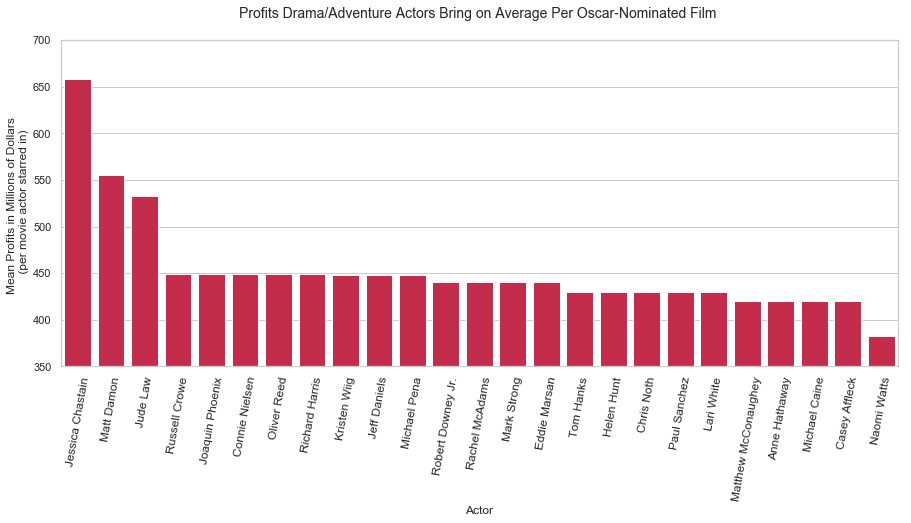

In [300]:
actors_plot = []
profits_plot = []
for actor in actors:
    actors_plot.append(actor[0])
    profits_plot.append(actor[1])

plt.figure(figsize = (15,6))
sns.barplot(x = actors_plot, y = profits_plot, color = 'crimson')
plt.xticks(rotation=80, fontsize = 12)
plt.xlabel('Actor', fontsize = 12)
plt.ylabel('Mean Profits in Millions of Dollars \n (per movie actor starred in)', fontsize = 12)
plt.title('Profits Drama/Adventure Actors Bring on Average Per Oscar-Nominated Film \n', fontsize = 14)
plt.ylim(350,700)
plt.show()